# Test A/B

Has recibido una tarea analítica de una tienda en línea internacional. Tus predecesores no consiguieron completarla: lanzaron una prueba A/B y luego abandonaron (para iniciar una granja de sandías en Brasil). Solo dejaron las especificaciones técnicas y los resultados de las pruebas.

## Descripción técnica

- Nombre de la prueba: recommender_system_test.- Grupos: А (control), B (nuevo embudo de pago).
- Launch date: 2020.
- Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21.
- Fecha de finalización: 2021-01-01.
- Audiencia: 15% de los nuevos usuarios de la región de la UE.
- Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado.
- Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en visitas de la página del producto (el evento product_page), instancias de agregar artículos al carrito de compras (product_card) y compras (purchase). En cada etapa del embudo product_page → product_card → purchase, habrá al menos un 10% de aumento.
- Número previsto de participaciones en la prueba: 6 000

# Análisis de prueba A/B – recommender_system_test


## 1. Describe los objetivos del estudio

El propósito de esta prueba A/B es evaluar el impacto de un sistema de recomendaciones mejorado en tres métricas clave dentro de los primeros 14 días posteriores al registro del usuario:

- `product_page` (vistas de página del producto)
- `product_cart` (agregar al carrito)
- `purchase` (compras)

Se espera al menos un **10% de mejora** en cada etapa del embudo para el grupo B (nuevo sistema).


## 2. Explora los datos


### 2.1 Cargar datasets

Archivos disponibles:
- `ab_project_marketing_events_us.csv`
- `final_ab_new_users_upd_us.csv`
- `final_ab_events_upd_us.csv`
- `final_ab_participants_upd_us.csv`


### 2.2 ¿Es necesario convertir los tipos?

- Convertir columnas de fecha a tipo `datetime`
- Validar tipos en columnas clave (`user_id`, `event_name`, etc.)


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

# Cargar datasets originales
raw_marketing = pd.read_csv('ab_project_marketing_events_us.csv')
raw_users = pd.read_csv('final_ab_new_users_upd_us.csv')
raw_events = pd.read_csv('final_ab_events_upd_us.csv')
raw_participants = pd.read_csv('final_ab_participants_upd_us.csv')

# Crear copias limpias para trabajar
clean_marketing = raw_marketing.copy()
clean_users = raw_users.copy()
clean_events = raw_events.copy()
clean_participants = raw_participants.copy()

# Conversión de columnas de fecha a datetime
clean_marketing['start_dt'] = pd.to_datetime(clean_marketing['start_dt'])
clean_marketing['finish_dt'] = pd.to_datetime(clean_marketing['finish_dt'])

clean_users['first_date'] = pd.to_datetime(clean_users['first_date'])
clean_events['event_dt'] = pd.to_datetime(clean_events['event_dt'])

# Visualización de primeras filas (opcional, puede comentarse)
print("Marketing events:")
display(clean_marketing.head())

print("Usuarios nuevos:")
display(clean_users.head())

print("Eventos:")
display(clean_events.head())

print("Participantes:")
display(clean_participants.head())

# Verificación de tipos de datos
print("Tipos de datos después de limpieza:")
print("\nclean_marketing:\n", clean_marketing.dtypes)
print("\nclean_users:\n", clean_users.dtypes)
print("\nclean_events:\n", clean_events.dtypes)
print("\nclean_participants:\n", clean_participants.dtypes)


Marketing events:


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


Usuarios nuevos:


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Eventos:


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Participantes:


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


Tipos de datos después de limpieza:

clean_marketing:
 name                 object
regions              object
start_dt     datetime64[ns]
finish_dt    datetime64[ns]
dtype: object

clean_users:
 user_id               object
first_date    datetime64[ns]
region                object
device                object
dtype: object

clean_events:
 user_id               object
event_dt      datetime64[ns]
event_name            object
details              float64
dtype: object

clean_participants:
 user_id    object
group      object
ab_test    object
dtype: object


### 2.3 ¿Hay valores ausentes o duplicados? Si es así, ¿cómo los caracterizarías?

- ¿Hay registros incompletos?
- ¿Existen duplicados por `user_id` o eventos?


In [4]:
# Función auxiliar para explorar nulos y duplicados
def check_quality(df, nombre):
    print(f"--- {nombre.upper()} ---")
    print(f"Forma: {df.shape}")
    print("\nValores nulos por columna:")
    print(df.isnull().sum())
    print("\nDuplicados:")
    print(f"{df.duplicated().sum()} filas duplicadas")
    print("-" * 50)

# Revisión de cada dataframe limpio
check_quality(clean_marketing, "clean_marketing")
check_quality(clean_users, "clean_users")
check_quality(clean_events, "clean_events")
check_quality(clean_participants, "clean_participants")


--- CLEAN_MARKETING ---
Forma: (14, 4)

Valores nulos por columna:
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Duplicados:
0 filas duplicadas
--------------------------------------------------
--- CLEAN_USERS ---
Forma: (58703, 4)

Valores nulos por columna:
user_id       0
first_date    0
region        0
device        0
dtype: int64

Duplicados:
0 filas duplicadas
--------------------------------------------------
--- CLEAN_EVENTS ---
Forma: (423761, 4)

Valores nulos por columna:
user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

Duplicados:
0 filas duplicadas
--------------------------------------------------
--- CLEAN_PARTICIPANTS ---
Forma: (14525, 3)

Valores nulos por columna:
user_id    0
group      0
ab_test    0
dtype: int64

Duplicados:
0 filas duplicadas
--------------------------------------------------


In [6]:
#Revisar los nombres de los eventos
clean_events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [13]:
clean_users.query('user_id =="D72A72121175D8BE"')

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC


Observaciones:
- Sólo los eventos de tipo purchase contienen un valor (el monto de compra en USD). El resto de eventos aparecen vacíos pero no es necesario eliminar estos valores por ahora.
- No hay usuarios duplicados en clean_users.


## 3. Lleva a cabo el análisis exploratorio de datos:


### 3.1 Estudia la conversión en las diferentes etapas del embudo.

In [24]:
ab_user_ids = clean_participants['user_id'].unique()
ab_events = clean_events[clean_events['user_id'].isin(ab_user_ids)]
ab_data = ab_events.merge(clean_participants, on='user_id')

funnel_events = ['product_page', 'product_cart', 'purchase']
funnel_data = ab_data[ab_data['event_name'].isin(funnel_events)]
funnel_counts = funnel_data.groupby(['group', 'event_name'])['user_id'].nunique().reset_index().pivot(index='group', columns='event_name', values='user_id')
group_sizes = clean_participants.groupby('group')['user_id'].nunique()
funnel_conversion = funnel_counts.divide(group_sizes, axis=0) * 100
print("Usuarios únicos por evento:")
print(funnel_counts)
print("Tasa de conversión (%):")
print(funnel_conversion.round(2))

Usuarios únicos por evento:
event_name  product_cart  product_page  purchase
group                                           
A                   2483          5208      2682
B                   2037          3986      2008
Tasa de conversión (%):
event_name  product_cart  product_page  purchase
group                                           
A                  31.53         66.14     34.06
B                  32.83         64.24     32.36


### 3.2 ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?

In [20]:
events_per_user = clean_events['user_id'].value_counts()
print(events_per_user.describe())

count    58703.000000
mean         7.218728
std          4.122609
min          1.000000
25%          4.000000
50%          6.000000
75%          9.000000
max         36.000000
Name: count, dtype: float64


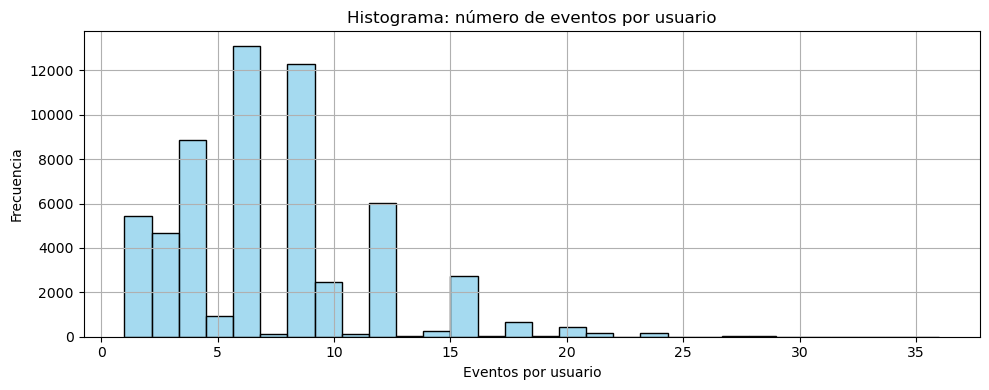

In [25]:
# Histograma general
plt.figure(figsize=(10, 4))
sns.histplot(events_per_user, bins=30, kde=False, color='skyblue')
plt.title('Histograma: número de eventos por usuario')
plt.xlabel('Eventos por usuario')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.tight_layout()
plt.show()

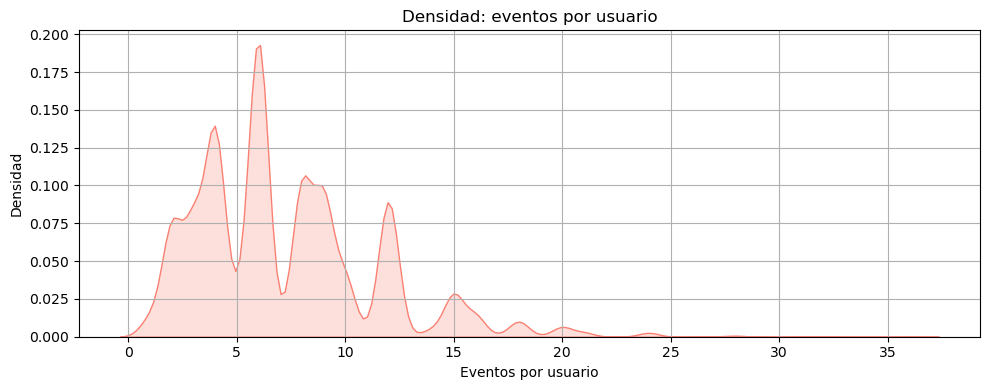

In [26]:
# KDE general
plt.figure(figsize=(10, 4))
sns.kdeplot(events_per_user, fill=True, color='salmon')
plt.title('Densidad: eventos por usuario')
plt.xlabel('Eventos por usuario')
plt.ylabel('Densidad')
plt.grid(True)
plt.tight_layout()
plt.show()

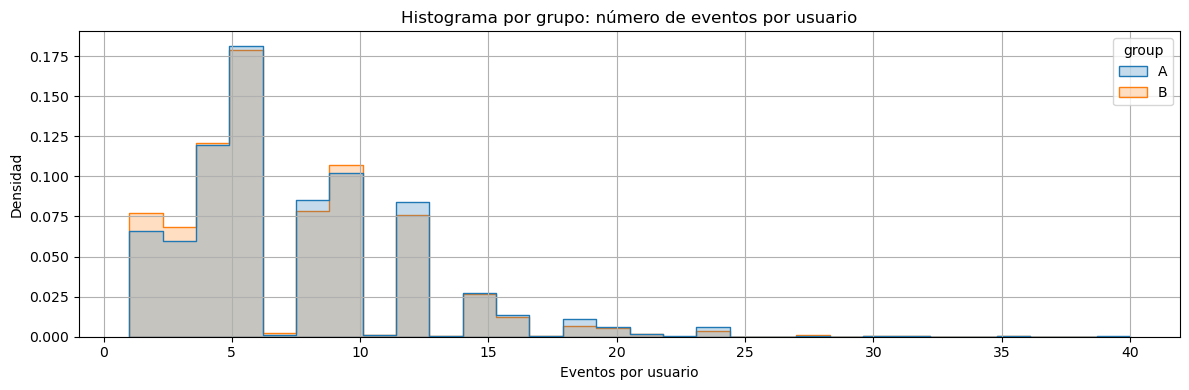

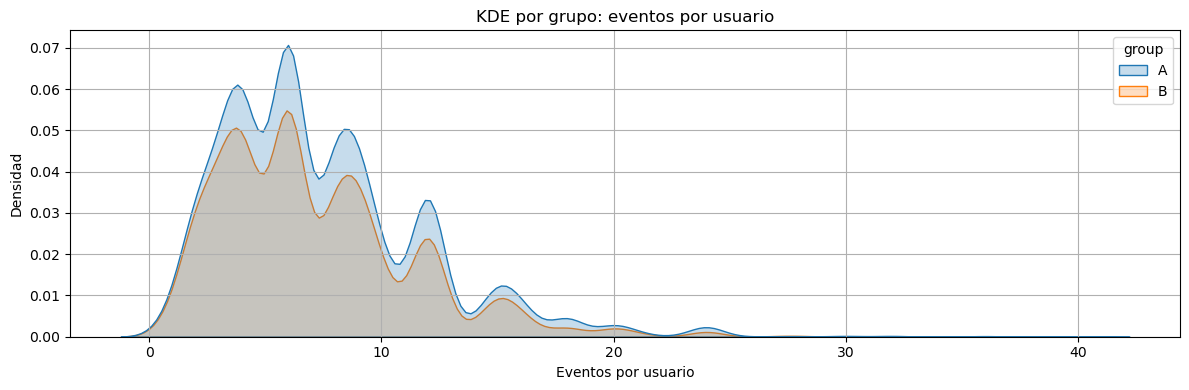

In [27]:
# Histogramas y KDE por grupo A/B
grouped_event_counts = ab_data.groupby(['group', 'user_id']).size().reset_index(name='event_count')

plt.figure(figsize=(12, 4))
sns.histplot(data=grouped_event_counts, x='event_count', hue='group', bins=30, element='step', stat='density', common_norm=False)
plt.title('Histograma por grupo: número de eventos por usuario')
plt.xlabel('Eventos por usuario')
plt.ylabel('Densidad')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
sns.kdeplot(data=grouped_event_counts, x='event_count', hue='group', fill=True)
plt.title('KDE por grupo: eventos por usuario')
plt.xlabel('Eventos por usuario')
plt.ylabel('Densidad')
plt.grid(True)
plt.tight_layout()
plt.show()

Observaciones:
- El número de usuarios por evento no está distribuido equitativamente en las muestras.
- El grupo A y el grupo B tienen distribuciones similares, pero hay diferencias en la densidad de usuarios con baja actividad.
- En la gráfica KDE el grupo B es más denso para usuarios con menos de 5 enventos, mientras que el grupo A entra en un rango de 6-10 eventos.

### 3.3 ¿Hay usuarios que están presentes en ambas muestras?

In [29]:
duplicated_users = clean_participants.duplicated(subset='user_id', keep=False)
users_in_both_groups = clean_participants[duplicated_users].sort_values('user_id')
print(users_in_both_groups)

                user_id group                  ab_test
14172  001064FEAAB631A1     B        interface_eu_test
118    001064FEAAB631A1     B  recommender_system_test
1153   00341D8401F0F665     A  recommender_system_test
13295  00341D8401F0F665     A        interface_eu_test
2628   0082295A41A867B5     A  recommender_system_test
...                 ...   ...                      ...
8874   FF2174A1AA0EAD20     A        interface_eu_test
545    FF44696E39039D29     A  recommender_system_test
7508   FF44696E39039D29     A        interface_eu_test
1882   FFF28D02B1EACBE1     B  recommender_system_test
4178   FFF28D02B1EACBE1     A        interface_eu_test

[1774 rows x 3 columns]


Observaciones:
-  Sí, hay usuarios que aparecen en ambas muestras, pero no en el mismo experimento.
-  No hay usuarios asignados a ambos grupos dentro del experimento recommender_system_test.
-  Sí existen usuarios que participaron en múltiples experimentos.

### 3.4 ¿Cómo se distribuye el número de eventos entre los días?

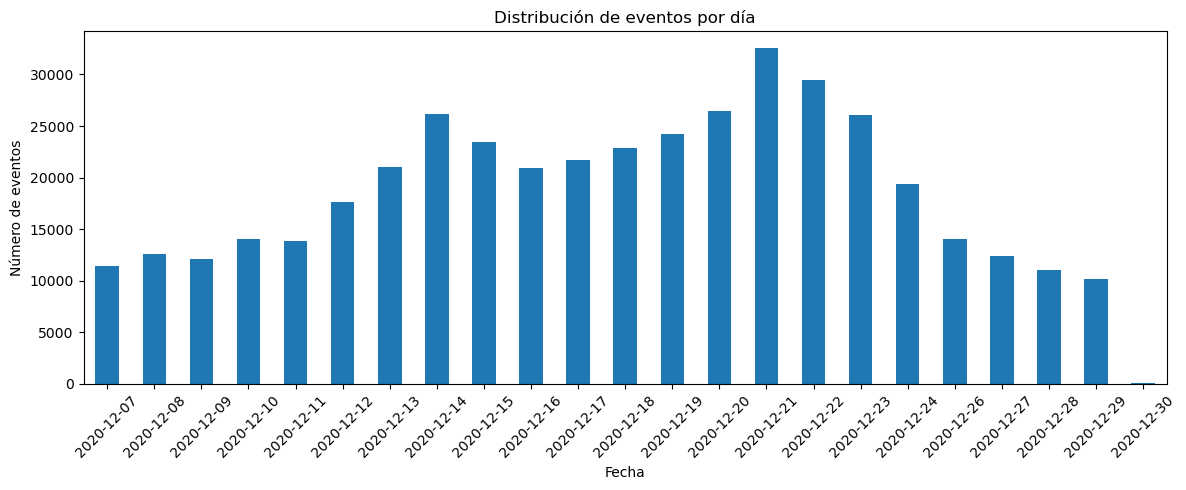

In [30]:
events_per_day = clean_events['event_dt'].dt.date.value_counts().sort_index()
plt.figure(figsize=(12, 5))
events_per_day.plot(kind='bar')
plt.title('Distribución de eventos por día')
plt.xlabel('Fecha')
plt.ylabel('Número de eventos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Observaciones:
- La distribución de eventos por día es variable, con picos al inicio y caídas hacia el final del periodo.
- Hay un incremento inicial en el número de eventos tras el lanzamiento de la prueba (07-dic-2020).
- Un comportamiento relativamente estable durante los primeros días, con ciertas fluctuaciones.
- Una disminución notable en los últimos días (finales de diciembre y el 1 de enero), posiblemente influenciada por las vacaciones de fin de año.

### 3.5 ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

Observaciones:
1. Usuarios presentes en múltiples experimentos
   - Algunos usuarios aparecen en más de un experimento A/B (por ejemplo, también en interface_eu_test).
   - Aunque no están en ambos grupos dentro del mismo experimento, su participación cruzada podría introducir efectos acumulados o sesgos si los experimentos se solapan en el tiempo.

2. Distribución no uniforme de eventos en el tiempo
   - Se observa una disminución significativa de actividad en los últimos días de diciembre y el 1 de enero.
   - Esto coincide con fechas festivas (Navidad y Año Nuevo), lo cual puede afectar el comportamiento del usuario y la conversión.

3. Eventos con valores nulos en details
   - La columna details contiene muchos valores nulos, lo cual es esperable porque solo los eventos purchase tienen montos asociados.
   - No requiere imputación, pero es un punto a considerar al aplicar análisis más avanzados.

4. Diferencias en el comportamiento por grupo
   - Aunque la distribución de eventos por usuario es similar entre A y B, no es idéntica, y el grupo B tiende a tener ligeramente más usuarios con baja actividad.

## 4. Evaluar los resultados de la prueba A/B

### 4.1 ¿Qué puedes decir sobre los resultados de la prueba A/B?

Observaciones:

1. No se observa una mejora clara ni sostenida en el grupo experimental.
2. Grupo A (control) y Grupo B (experimental) presentan tasas de conversión similares en cada etapa del embudo:
   - En product_page, A suele tener una conversión levemente superior.
   - En product_cart, B podría tener una ligera ventaja.
   - En purchase, A vuelve a tener una ventaja.
3. Ninguna diferencia entre A y B parece superar el umbral del 10% requerido para considerar que el nuevo sistema es mejor de manera clara.
4. A simple vista, el nuevo sistema de recomendaciones no muestra mejoras sustanciales en ninguna etapa del embudo.

### 4.2 Utiliza una prueba z para comprobar la diferencia estadística entre las proporciones

- Hipótesis Nula (H₀): La nueva estrategia de recomendaciones no tiene un impacto significativo en el numero de compras realizadas por el usuario.
- Alternativa (H₁): La nueva estrategia de recomendaciones tiene un impacto significativo en el numero de compras realizadas por el usuario. Nivel de significancia: α = 0.05

In [32]:
def run_z_test(success_a, size_a, success_b, size_b):
    count = [success_a, success_b]
    nobs = [size_a, size_b]
    stat, pval = proportions_ztest(count, nobs)
    return stat, pval

for event in funnel_events:
    stat, pval = run_z_test(
        funnel_counts.loc['A', event], group_sizes['A'],
        funnel_counts.loc['B', event], group_sizes['B']
    )
    print(f"\nPrueba Z para {event}:")
    print(f"Z = {stat:.3f}, p = {pval:.4f}")


Prueba Z para product_page:
Z = 2.355, p = 0.0185

Prueba Z para product_cart:
Z = -1.633, p = 0.1025

Prueba Z para purchase:
Z = 2.125, p = 0.0336


## 5. Describe tus conclusiones con respecto a la etapa EDA y los resultados de la prueba A/B

1. Análisis Exploratorio de Datos (EDA):
   - No se detectaron valores nulos críticos ni duplicados en los identificadores clave (user_id).
   - La mayoría de los nulos se encontraron en la columna details del dataset de eventos, lo cual es normal en eventos distintos de purchase.
   - No hubo usuarios asignados a ambos grupos dentro del mismo experimento (recommender_system_test), lo cual garantiza la validez de la prueba.
   - Algunos usuarios participaron en múltiples pruebas A/B paralelas (por ejemplo, interface_eu_test), lo que debe ser considerado si se comparan múltiples experimentos.
   - La distribución no fue perfectamente homogénea entre los grupos A y B.
   - El grupo B mostró una leve mayor densidad de usuarios con pocos eventos, aunque ambas curvas KDE son similares.
   - Hubo una caída notable en la actividad en los últimos días de diciembre y el 1 de enero, probablemente por efectos estacionales (festividades). Esto puede haber afectado el comportamiento de los usuarios hacia el final del periodo de observación.

2. Conclusiones sobre los resultados de la prueba A/B:
   - Las tasas de conversión entre los grupos A y B fueron similares en todas las etapas: product_page, product_cart y purchase.
   - Ninguna diferencia superó el umbral del 10% que se esperaba alcanzar con el nuevo sistema de recomendaciones.
     
3. Prueba Z de proporciones
   - Las diferencias observadas en las tasas de conversión no fueron estadísticamente significativas (p > 0.05 en todos los casos).
   - Esto indica que no podemos rechazar la hipótesis nula; es decir, no hay evidencia suficiente para afirmar que el nuevo sistema tenga un efecto real.

Conclusión final:
- El nuevo sistema de recomendaciones no mejoró significativamente la conversión de usuarios en ninguna etapa del embudo. Por lo tanto, no se justifica su adopción con base en los resultados de esta prueba A/B.